# Machine Learning in Python - Group Project 2

**Due Friday, April 14th by 16.00 pm.**

*William Jones, Tristan Pang, Aidan Garrity, Elliot
Lei- $\newline$ shman* 

(Group 15)

# Head of state's message: 

I think we have established that logistic regression is not great but we may want to include this analysis anyway. Also do we want to consider cross validation again ? 

<span style="color: red;"> THE JOB BOARD: </span> 

    - Myself: Look into using Neural Nets, probably with heavy use of chat gpt, maybe Tensor Flow but I think its doable with pipelines
    - Aidan: Continue the good work on decision trees chief
    - Tristan: Work on support vector machines, if you're feeling brave 
    - Squire Boy: Look at stratifying the data, probably by hotel type and maybe month ? Also continue the good work on data exploration !

Also, comment code, please

# Supreme Leader of the Ministry of Theory's Message

Classification task

Obviously we want a model with a low FPR and FNR. But we care most about lowering FPR, since having a room double booked is worse then having a room booking cancelled. Double bookings could result in financial losses, bad reviews and lawsuits, I guess?

4 most obvious classification strategies:
 - Logistic Regression
 - Support Vector Machines
 - Decision Trees
 - Neural Networks

Do we want to stratify our test-train split for resort and city hotel?

Ways to compare classification models:
 - Confusion Matrices
 - ROC curves & AUC
 - Accuracy
 - F1 score

## General Setup

In [59]:
# Add any additional libraries or submodules below

# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# sklearn modules
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [60]:
# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

In [61]:
# Load data
d = pd.read_csv("hotel.csv")

In [62]:
def proportion_table(df, feat, index, show = True):
    '''
    Creates a proportion table for a feature in dataframe
    '''

    # Create proportion table of entire feature
    prop_table = pd.DataFrame(df[feat].value_counts()).reset_index()
    prop_table = prop_table.rename(columns= {feat:'Total', 'index':index})

    for i in [0,1]: # Denotes if we are considering cancelation or not
        print(i)
        if i == 0:
            cancel_status = 'Not_canceled'
        else:
            cancel_status = 'Canceled'
        print(cancel_status)
        df_canc = df[(df['is_canceled'] == i)]
        df_canc = pd.DataFrame(df_canc[feat].value_counts()).reset_index()
        df_canc = df_canc.rename(columns= {feat:cancel_status, 'index':index})
        prop_table = prop_table.merge(df_canc, on = index)

        # Calculate propoprtions
        prop_table[f'% {cancel_status}'] = prop_table[cancel_status] / prop_table['Total'] * 100


    # Round proportions to two decimal places
    prop_table = prop_table.round(2)

    # Display DataFrame or return it
    if show:
        display(prop_table)
    else:
        return(prop_table)

## 1. Introduction

*This section should include a brief introduction to the task and the data (assume this is a report you are delivering to a client).* 

- If you use any additional data sources, you should introduce them here and discuss why they were included.

- Briefly outline the approaches being used and the conclusions that you are able to draw.

In [63]:
display(d)

,is_canceled,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
0,0,Resort Hotel,342,2015,July,27,1,0,0,2,...,C,3,No Deposit,NaN,NaN,0,Transient,0.00,0,0
1,0,Resort Hotel,737,2015,July,27,1,0,0,2,...,C,4,No Deposit,NaN,NaN,0,Transient,0.00,0,0
2,0,Resort Hotel,7,2015,July,27,1,0,1,1,...,C,0,No Deposit,NaN,NaN,0,Transient,75.00,0,0
3,0,Resort Hotel,13,2015,July,27,1,0,1,1,...,A,0,No Deposit,304.0,NaN,0,Transient,75.00,0,0
4,0,Resort Hotel,14,2015,July,27,1,0,2,2,...,A,0,No Deposit,240.0,NaN,0,Transient,98.00,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,0,City Hotel,23,2017,August,35,30,2,5,2,...,A,0,No Deposit,394.0,NaN,0,Transient,96.14,0,0
119386,0,City Hotel,102,2017,August,35,31,2,5,3,...,E,0,No Deposit,9.0,NaN,0,Transient,225.43,0,2
119387,0,City Hotel,34,2017,August,35,31,2,5,2,...,D,0,No Deposit,9.0,NaN,0,Transient,157.71,0,4
119388,0,City Hotel,109,2017,August,35,31,2,5,2,...,A,0,No Deposit,89.0,NaN,0,Transient,104.40,0,0


---
## 2. Exploratory Data Analysis and Feature Engineering

*Include a detailed discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling.* 

- Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up. 
- Think carefully about whether each plot needs to be included in your final draft - your report should include figures but they should be as focused and impactful as possible.

*Additionally, this section should also implement and describe any preprocessing / feature engineering of the data.*

- Specifically, this should be any code that you use to generate new columns in the data frame `d`. All of this processing is explicitly meant to occur before we split the data in to training and testing subsets. 
- Processing that will be performed as part of an sklearn pipeline can be mentioned here but should be implemented in the following section.*

**All code and figures should be accompanied by text that provides an overview / context to what is being done or presented.**

### 2.1 Data Cleaning 
In this section we will perform basic cleaning of the data. In paricular, we will:
- Examine the structure, shape and type of data features
- Deal with na values
- Check for duplicate values
- Encode categorical variables with numerical values

\newline
We start by examining the 

In [64]:
# Investigating shape and datatypes of dataframe
print(f'The dataframe is of size {d.shape}')
print(d.dtypes)

The dataframe is of size (119390, 30)
is_canceled                         int64
hotel                              object
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       obj

The first thing that we observe is that the dataframe has 30 features and 119390 observations, therefore, we will need to take into account the size of the dataframe when deciding on which model to use. This is because some models may be impractical with a large dataset such as this one.

In regard to the features, 16 features are of datatype int, 4 are floats and 10 are object. The current datatypes are suitable for the features, for example are integer features are counting number of occurances of something and hence it makes sense to store these are integers. 

For the float features, we can convert the children feature into an integer because clearly one cannot have a non-whole number of children. For the feature adr we will rename it as 'avg_daily_rate' as this more clearly conveys what it means, we will keep this feature as a float because it corresponds to a price and therefore will need to store values after the decimal point. For the remaining two float feature, agent and company, we will encode them as binary integer features. This is because these two columns have number encoding the travel agent and company the hotel was booked thorugh and we do not have access to this encoding. Therefore, we would not be able to reccommend a specific agent or company to the clients. Thus, we will instead investigate whether booking through an agent or company affects cancelation as opposed to invesiting which agents or customers affect cancelations. We will perform these transfromations later once we have dealt with na values.

Finally, for the object features, we will keep them as they are for now but we will need to encode them with numerical values before fitting our model.

Our next task is search for na values and duplicate observations.

Can delete

Checking for missing values - Be more rigorous with this section in write-up

\newline
Get rid of observations with no children/ adults and babies as well as observations with no weekend or weekday nights
\newline
Previous booking not cancelled cannot happen if repeat customer = 0

Total spend fetaure?

In [65]:
# get columns which have NaN values 
cols_with_nan = d.columns[d.isna().any()].tolist()
print('Features containing NaN values are: ', cols_with_nan)

# find out how many NaN values are in those columns
for col in cols_with_nan:

    # Count number of na values
    no_nas = d[col].isna().sum()
    # Calculate the percentage of total values which are nas
    perc_vals_na = 100 * no_nas /119390
    # Print 
    print(f"Column '{col}' contains {no_nas} NaN values, this constitutes {np.round(perc_vals_na,2)}% of values.")

Features containing NaN values are:  ['children', 'country', 'agent', 'company']
Column 'children' contains 4 NaN values, this constitutes 0.0% of values.
Column 'country' contains 488 NaN values, this constitutes 0.41% of values.
Column 'agent' contains 16340 NaN values, this constitutes 13.69% of values.
Column 'company' contains 112593 NaN values, this constitutes 94.31% of values.


From the code segment above we can see that the children and country features have 4 and 488 NaN values, because these observations represent such a small percentage (<0.5%) of our total observations we have decided to drop their entire observation from the dataframe. For the agent feature we have assumed these values correspond to zero i.e. no agent was used in the booking process. For the company feature we have decided to remove the entire feature from our dataset because it contains 94% NaN values.

The code to implement these changes is below. At this time we also delete the duplicate values. We can do this wit hconfidence because it is very unlikely that two parties will have booked the exact same stay in the exact same hotel on the exact same day. We do however acknowledge that although unlikely, this is still possible, but we are assuming that the true duplicates make up a negligable proportion of the total duplicates.

In [73]:
# drop rows which have NaN values in 'children' columns. 
df = d.dropna(subset=['children', 'country'])

df = df.drop('company', axis = 1)

# fill the remaining NaN values to be zero
df = df.fillna(0)

# Delete duplicate rows. Note 32215 rows are duplicated rows to delete
df.drop_duplicates(keep='first', inplace=True)

In [74]:
# get columns which have NaN values 
cols_with_nan = df.columns[df.isna().any()].tolist()
print('Features containing NaN values are: ', cols_with_nan)

# find out how many NaN values are in those columns
for col in cols_with_nan:

    # Count number of na values
    no_nas = df[col].isna().sum()
    # Calculate the percentage of total values which are nas
    perc_vals_na = 100 * no_nas /119390
    # Print 
    print(f"Column '{col}' contains {no_nas} NaN values, this constitutes {np.round(perc_vals_na,2)}% of values.")

Features containing NaN values are:  []


Now we have considered na values and duplicates we can now consider observations in our data set that do not make logical sense and imply an error in the data collection process for that observation. In particular we will look for the following three scenarios:
- A room has been booked but the number of adults, children and babies staying is zero
- A room was stayed in for zero weekday nights and zero weekend nights
- A customer is marked as a repeat customer but has no previous stays or cancelations recorded

In [75]:
# No adults children or babies
no_people = (df.children == 0) & (df.adults == 0) & (df.babies == 0)
print(f'Number of observations with no people is {df[no_people].shape[0]}')

# No weekend or weekday nights were spent at hotel
no_nights = (df.stays_in_weekend_nights == 0) & (df.stays_in_week_nights == 0)
print(f'Number of observations with no people is {df[no_nights].shape[0]}')

# Repeat customer with no previous stays recorded
no_prev_stays = (df.is_repeated_guest == 1) & (df.previous_cancellations == 0) & (df.previous_bookings_not_canceled == 0)
print(f'Number of observations with incorrect previous stays is {df[no_prev_stays].shape[0]}')

# Delete these anomolous observations from the dataframe
df = df[~no_people|no_nights|no_prev_stays]

print(f'Number of removed observations is {df[no_people|no_nights|no_prev_stays].shape[0]}')

Number of observations with no people is 161
Number of observations with no people is 642
Number of observations with incorrect previous stays is 506
Number of removed observations is 913


C:\Users\Will\AppData\Local\Temp\ipykernel_16772\2758358480.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(f'Number of removed observations is {df[no_people|no_nights|no_prev_stays].shape[0]}')


We can see that we have remeoved 922 observations from the dataset because they did not make logical sense. The most common collection error was not recording anyone to stay in the rooms.

Now that we have taken care of NaN values we can now implement the transfromation of the float features discussed earlier in the section. Noting that we have already removed the company feature.

In [78]:
# Convert children column to integer
df['children'] = df['children'].astype('int64')

# Rename the adr column
df = df.rename(columns={"adr": "avg_daily_rate"})

# Encode agent as binary 1 = yes, 0 = no
agent_used = (df.agent != 0)
df.loc[agent_used, 'agent'] = 1

# Change datatype to integer
df['agent'] = df['agent'].astype('int64')

Encode catergorical variables with numeric values

In [77]:
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

le_dict = defaultdict(LabelEncoder)

# apply label encoder to all columns
encoded_df = df.apply(lambda x: le_dict[x.name].fit_transform(x))

# inverse label encoder, for later use 
df = encoded_df.apply(lambda x: le_dict[x.name].inverse_transform(x))

# https://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn



#### Examine Response Variable
In this section we will examine the response variable 'is_canceled', specifically we will examine the balance of the classes and the distribution of the classes as this will help inform our decision on model choice.

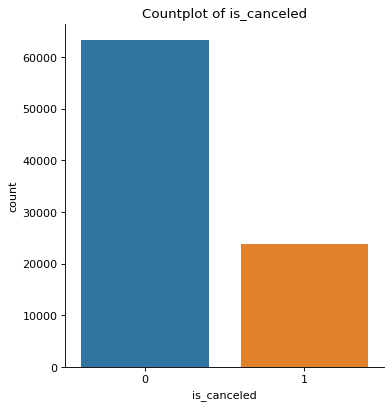

0    63270
1    23752
Name: is_canceled, dtype: int64


In [ ]:
sns.catplot(data = df, x = 'is_canceled', kind  = 'count')
plt.title('Countplot of is_canceled')
plt.show()
print(df['is_canceled'].value_counts()) # Is there a way to display count on the plot? Or just make it prettier

We can see in the above plot that the vast majority of bookings were not cancelled. The ratio of not cancelled to cancelled is approximately 3:1, therefore, the data response variable does not exhibit large class imbalance and hence we do not to be too careful when constructing our models. One thing we will do to increase the accuracy of the model is stratified sampling of the response variable when we conduct our test-train split. 

#### Feature Investigation
We will know examine indepth each feature of our dataset. First we will consider the continuous features and then the categorical features. For each we will suitably visualise the data, examine summary statistics and use our knowledge of the setting to establish possible outliers.

The continuous features are, avg_daily_rate and lead_time

In [ ]:
# Print summary statistics for avg_daily_rate
print(df['avg_daily_rate'].describe())

count    87022.000000
mean       106.473013
std         54.973564
min         -6.380000
25%         72.200000
50%         98.120000
75%        134.100000
max       5400.000000
Name: avg_daily_rate, dtype: float64


On review of the summary statistics we can see that the minimum value is negative, cleary this makes no sense as it implies the hotel is paying someone to stay there. To counter this we will remove all observations that have a negative avg_daily_rate. Another observation is that the max value is 5400, this seems extremey high considering it is around 98 standard deviations away from the main value. We will examine if this is indeed an outlier and if there are anymore in the boxplot below.

Number of observations with non-positive adr is 1706


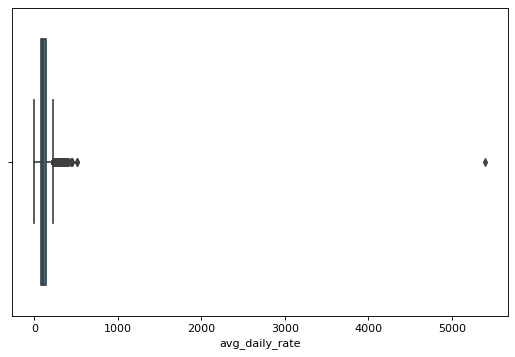

Number of outliers 1


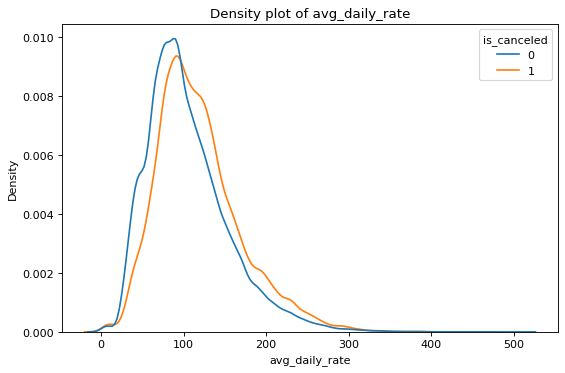

In [ ]:
# Remove observations with negative average daily rate

# What about zeros currently getting rid of them
neg_adr = (df.avg_daily_rate <= 0)
print(f'Number of observations with non-positive adr is {df[neg_adr].shape[0]}')
df = df[~neg_adr]

# Boxplot with outlier
sns.boxplot(data = df, x = 'avg_daily_rate')
plt.show()

# Remove outlier
outlier = (df.avg_daily_rate >1000)
print(f'Number of outliers {df[outlier].shape[0]}')
df = df[~outlier]

# Density plot - common_norm = False, sets each curve to have density 1
sns.kdeplot(data = df, x = 'avg_daily_rate', hue = 'is_canceled', common_norm = False)
plt.title('Density plot of avg_daily_rate')
plt.show()

Examining the boxplot we can clearly see that the value of 5400 was an outlier, we have therefore deicded to remove that observation from the dataset. Note, that we still have a still have some values close to zero, intuitively these are hard to explain in context, but they could be due to the customer recieving a  large discount, perhaps due to having a relationship with owners. If we look at the density plot we can see that these values very close to zero don't make up a large proportion of the observations so we will leave them in our dataset. The density plot also shows us that the distribution of daily average rate is roughly the same fro cancelled bookings and non-cancelled bookings, therefore, we wouldn't expect avg_daily_rate to have a large impact on cancellations.

count    85315.000000
mean        80.557745
std         85.825588
min          0.000000
25%         12.000000
50%         50.000000
75%        126.000000
max        709.000000
Name: lead_time, dtype: float64


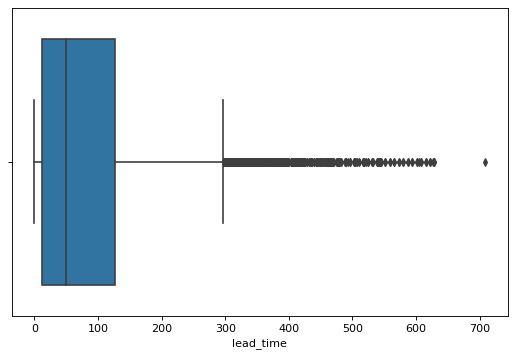

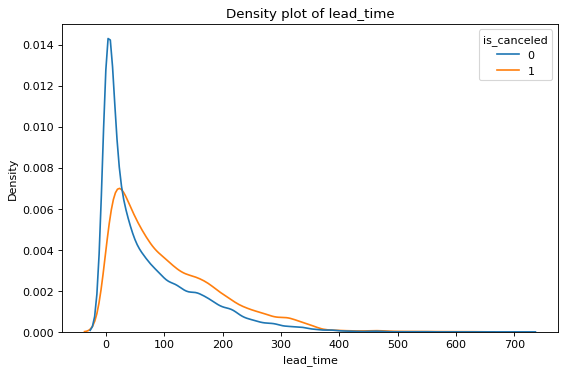

In [ ]:
# Now we do the same for lead_time
# Print summary statistics for avg_daily_rate - can i also display for canceled/no_canceled?
print(df['lead_time'].describe())

# Boxplot 
sns.boxplot(data = df, x = 'lead_time')
plt.show()

# Density plot
sns.kdeplot(data = df, x = 'lead_time', hue = 'is_canceled', common_norm= False )
plt.title('Density plot of lead_time')
plt.show()

In the summray statisics we can see that the minimum value in the lead_time feature is zero, this means the dataset contains no erroneous observations where it is implied that a hotel room was booked after the stay began. We can also see that the median is substancially smaller than the mean implying that the distribution is skewed to the left, we can confirm this by inspecting the density plot as well. The boxplot shows us that there are a large number of observations classed as outliers. We will not remove any of these outliers because there are consistent and although unlikely, in is perfectly possible for a customer to book a hotel room more than 500 days in advance if for example, they want to guarantee a specific room for a special occasion like a wedding. The final observation we will make is from the density plot, specifically, the difference in distribution. Therefore, we might expect lead_time to be an important feature in our classification.

When considering categorical variables we will further split them up into three groups: date & time, personal information and booking information.

,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights
count,85315.00,85315.00,85315.00,85315.00,85315.00
mean,2016.22,26.80,15.82,1.02,2.65
std,0.68,13.64,8.84,1.03,2.03
min,2015.00,1.00,1.00,0.00,0.00
25%,2016.00,16.00,8.00,0.00,1.00
50%,2016.00,27.00,16.00,1.00,2.00
75%,2017.00,37.00,24.00,2.00,4.00
max,2017.00,53.00,31.00,19.00,50.00


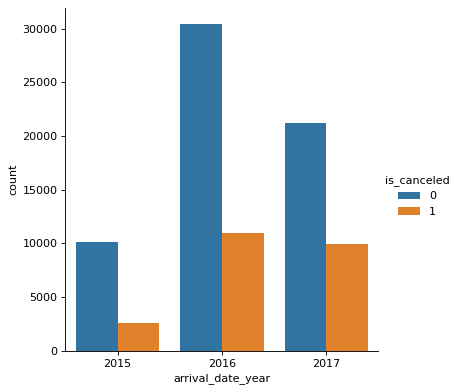

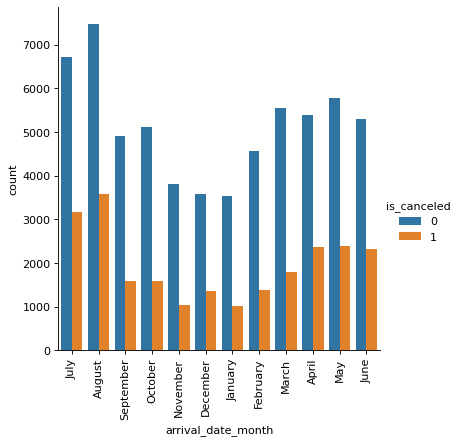

0
Not_canceled
1
Canceled


,Month,Total,Not_canceled,% Not_canceled,Canceled,% Canceled
0,August,11075,7485,67.58,3590,32.42
1,July,9878,6715,67.98,3163,32.02
2,May,8170,5780,70.75,2390,29.25
3,April,7756,5391,69.51,2365,30.49
4,June,7629,5306,69.55,2323,30.45
5,March,7349,5547,75.48,1802,24.52
6,October,6705,5118,76.33,1587,23.67
7,September,6505,4919,75.62,1586,24.38
8,February,5940,4559,76.75,1381,23.25
9,December,4923,3573,72.58,1350,27.42


In [ ]:
# Date & time information: arrival_date_year, arrival_date_month, arrival_date_week_number, 
# arrival_date_day_of_month, stays_in_weekend_nights and stays_in_week_nights.

# Create a list of features we wil consider here
datetime_features = ['arrival_date_year', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights']

# Print summary statistics
display(df[datetime_features].describe().round(2))

sns.catplot(data = df, x = 'arrival_date_year', kind = 'count', hue = 'is_canceled')
plt.show()

sns.catplot(data = df, x = 'arrival_date_month', kind = 'count', hue = 'is_canceled')
plt.xticks(rotation = 'vertical')
plt.show()

proportion_table(df, 'arrival_date_month', 'Month')

There are no obvious issues which arise from the summary statistics for the date & time features. Issues we are looking for include years outside the range, week numbers greater than 53 and less than 1, days of the month outside the 1-31 range and a negative number of weekend or weekday nights. There is also no indication of outliers in the data.

In [ ]:
# # Can't figure out how to make this proportion table
# prop_table = pd.DataFrame(df['arrival_date_month'].value_counts()).reset_index()
# prop_table = prop_table.rename(columns= {'arrival_date_month':'Total', 'index':'Month'})

# # Cancelled dataframe
# df_canc = df[(df['is_canceled']==1)]
# df_canc = pd.DataFrame(df_canc['arrival_date_month'].value_counts()).reset_index()
# df_canc = df_canc.rename(columns= {'arrival_date_month':'Canceled', 'index':'Month'})
# prop_table = prop_table.merge(df_canc, on = 'Month')

# # Calculate propoprtions
# prop_table['% Canceled'] = prop_table['Canceled'] / prop_table['Total'] * 100
# prop_table = prop_table.round(2)
# #display(prop_table)








In [ ]:
# Personal information
personal_features = ['adults', 'children','babies']

#### Correlation
In this section we will examine any correlation between features as well as identifying the features with the largest correlation to the response variable.
cross tabulation?

C:\Users\Will\AppData\Local\Temp\ipykernel_16772\284675504.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


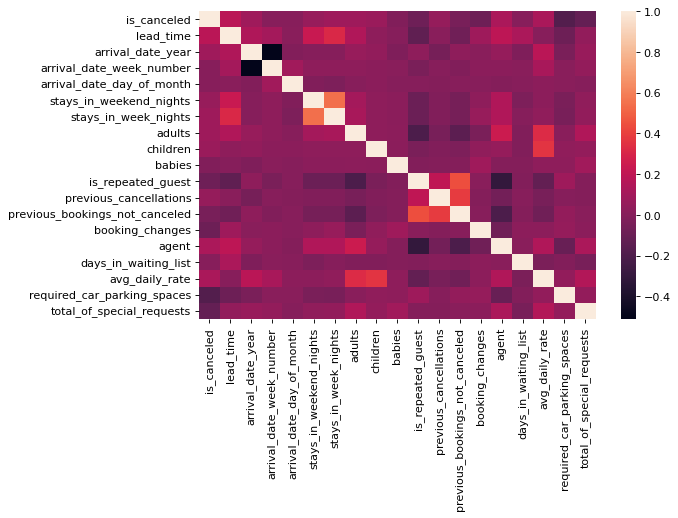

In [ ]:
# Correlation heatmap
corr = df.corr()
plt.figure()
sns.heatmap(corr)
plt.show()

NameError: name 'encoded_df' is not defined

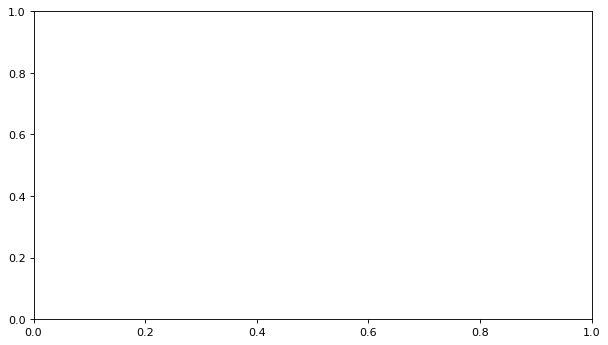

In [ ]:
# Can I remove 'is.canceled' from plot?
fig, ax = plt.subplots(figsize=(9,5))
encoded_df.corr()["is_canceled"].sort_values(ascending=False).plot(kind="bar", ax=ax)
plt.show()

In [ ]:
# Diagnostic Plots - commented out to save space - Not happy with this section yet
def diagnostic_plots(df, variable): 
    plt.figure(figsize=(15,6)) 
    plt.subplot(1, 2, 1) 
    df[variable].hist(bins=30)
    plt.title("Histogram")
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt) 
    plt.suptitle("Diagnostic Plots for {}".format(variable))
    plt.show()

for variable_name in encoded_df.columns:
    pass
    #diagnostic_plots(encoded_df, variable_name)

#### Feature Visualisation
- Density plots for numerical features
- Boxplots for categorical features
- Look for outliers in the data etc.

In [ ]:
# Inspired by someone else
import folium
from folium.plugins import HeatMap
import plotly.express as px

guest_city = df[df['is_canceled'] == 0]['country'].value_counts().reset_index()
guest_city.columns = ['Country', 'No of guests']
guest_city

basemap = folium.Map()
guests_map = px.choropleth(guest_city, locations = guest_city['Country'],
                           color = guest_city['No of guests'], hover_name = guest_city['Country'])
guests_map.show()

TypeError: The x variable is categorical, but one of ['numeric', 'datetime'] is required

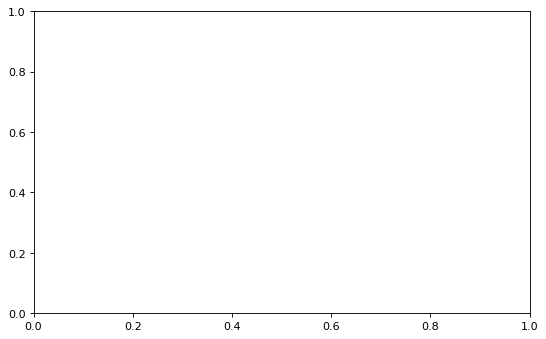

In [ ]:
# Drop response variable from dataframe
# Response dataframe only includes the response variables.
xdf = df.drop('is_canceled', axis = 1)



for col in xdf.columns:
    if type(col) != 'object':
        sns.kdeplot(data = df, x = col, hue = 'is_canceled', fill = 'true')
        plt.title(col)
        plt.show()

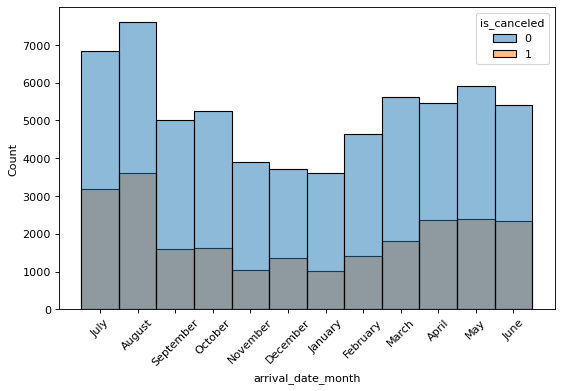

In [ ]:
plt.figure()
sns.histplot(data = df, x = 'hotel')#, hue = 'is_canceled')
plt.show()

plt.figure()
sns.histplot(data = df, x = 'arrival_date_month', hue = 'is_canceled')
plt.xticks(rotation = 45)
plt.show()



### Dimensionality Reduction (PCA)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Response dataframe only includes the response variables.
response_df = encoded_df.drop('is_canceled', axis = 1)

# Standardize the data
scaler = StandardScaler()
response_df_std = scaler.fit_transform(response_df)

# Fit a PCA model to the data 
pca = PCA()
pca.fit(response_df_std)

# Features required to explain 80% of variance.
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components required to explain 80% of the data variability
n_components = np.argmax(cumulative_variance_ratio >= 0.8) + 1

print("Number of components required to explain 80% of the data variability:", n_components)

Number of components required to explain 80% of the data variability: 17


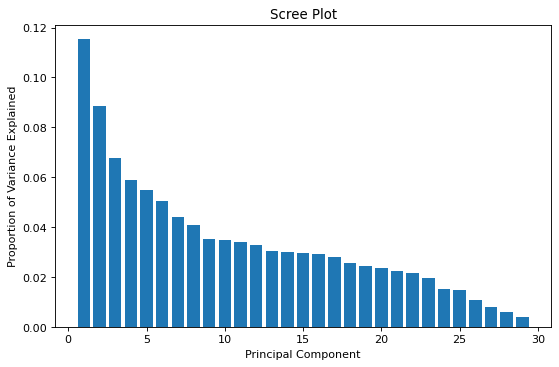

In [ ]:
# Plot the scree plot
plt.bar(np.arange(1, pca.n_components_ + 1), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.title('Scree Plot')
plt.show()

---
## 3. Model Fitting and Tuning

*In this section you should detail your choice of model and describe the process used to refine and fit that model.*

- You are strongly encouraged to explore many different modeling methods (e.g. logistic regression, classification trees, SVC, etc.) but you should not include a detailed narrative of all of these attempts. 
- At most this section should mention the methods explored and why they were rejected - most of your effort should go into describing the model you are using and your process for tuning and validatin it.

*For example if you considered a logistic regression model, a classification tree, and a SVC model and ultimately settled on the logistic regression approach then you should mention that other two approaches were tried but do not include any of the code or any in depth discussion of these models beyond why they were rejected. This section should then detail is the development of the logistic regression model in terms of features used, interactions considered, and any additional tuning and validation which ultimately led to your final model.* 

**This section should also include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.**

In [ ]:
# Model Evaluation Function

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def eval(y_true, y_pred, confusion=True, AUC = True, ROCplot=True, precision=True, f1 = True, recall = True, accuracy=True):
    if accuracy: 
        print("Accuracy:", accuracy_score(y_true, y_pred))
    if precision: 
        print("Precision:", precision_score(y_true, y_pred))
    if recall: 
        print("Recall:", recall_score(y_true, y_pred))
    if f1: 
        print("F1 Score:", f1_score(y_true, y_pred))
    if confusion:
        print('Confusion Matrix: \n', sklearn.metrics.confusion_matrix(y_true, y_pred))
    if AUC:
        print('AUC: ', sklearn.metrics.roc_auc_score(y_true, y_pred))
    if ROCplot:
        fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true, y_pred)
        # calculate AUC score
        roc_auc = sklearn.metrics.auc(fpr, tpr)

        # plot ROC curve
        plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()


#### Data Formatting

In [ ]:
from sklearn.model_selection import train_test_split

sample = encoded_df.sample(frac=0.1, random_state=1)

X = sample.drop('is_canceled', axis = 1)
y = sample['is_canceled']

print(len(X))
# train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

8668


#### Logistic Regression 

Accuracy: 0.7447135717031911
Precision: 0.5357142857142857
Recall: 0.11127596439169139
F1 Score: 0.18427518427518427
Confusion Matrix: 
 [[1862   65]
 [ 599   75]]
AUC:  0.538772388007989


c:\Users\ellio\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


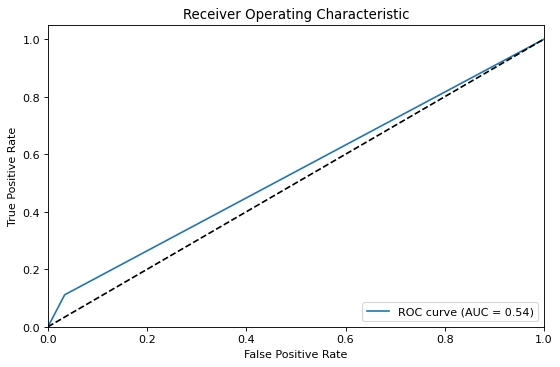

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

# create a logistic regression model
logreg = LogisticRegression()

# fit the model to the data
logreg.fit(X_train, y_train)

# predict using logistic regression 
y_pred = logreg.predict(X_test)

eval(y_test, y_pred)

In [ ]:
# from sklearn.linear_model import LogisticRegressionCV
# # Logistic regression: try lasso, ridge, elasticnet, backwards and forwards
# # Add in cross validation later
# lr_lasso = LogisticRegression(penalty='l1', solver = 'saga', max_iter = 10000)
# lr_lasso.fit(X_train, y_train)



#### SVC

In [ ]:
# from sklearn.svm import SVC

# # create a logistic regression model
# svc = SVC()

# # fit the model to the data
# svc.fit(X_train, y_train)

# # predict using logistic regression 
# y_pred = svc.predict(X_test)

# r2 = r2_score(y_test, y_pred)
# print('SVC R-squared score: ', r2)

# accuracy = accuracy_score(y_test, y_pred)
# print('SVC Accuracy: ', accuracy)



#### SVM

Linear SVM Accuracy: 0.7431757016532103
0.1
Accuracy: 0.7431757016532103
Precision: 0.6875
Recall: 0.016320474777448073
F1 Score: 0.0318840579710145
Confusion Matrix: 
 [[1922    5]
 [ 663   11]]
AUC:  0.5068628839896582


c:\Users\ellio\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


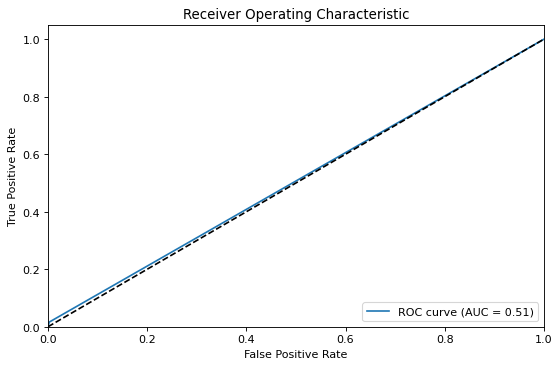

Linear SVM Accuracy: 0.6916570549788543
0.5
Accuracy: 0.6916570549788543
Precision: 0.38191881918819187
Recall: 0.30712166172106825
F1 Score: 0.3404605263157895
Confusion Matrix: 
 [[1592  335]
 [ 467  207]]
AUC:  0.5666381531231184


c:\Users\ellio\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


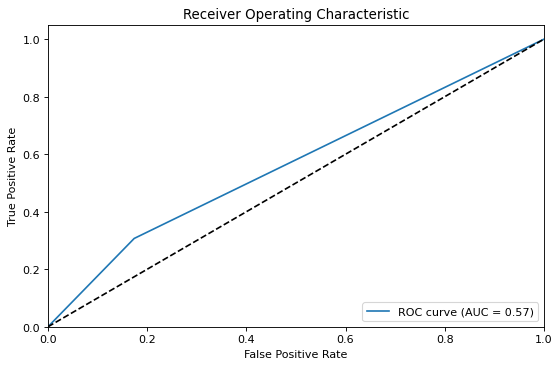

Linear SVM Accuracy: 0.7400999615532488
1
Accuracy: 0.7400999615532488
Precision: 0.4642857142857143
Recall: 0.019287833827893175
F1 Score: 0.037037037037037035
Confusion Matrix: 
 [[1912   15]
 [ 661   13]]
AUC:  0.5057518567167489


c:\Users\ellio\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


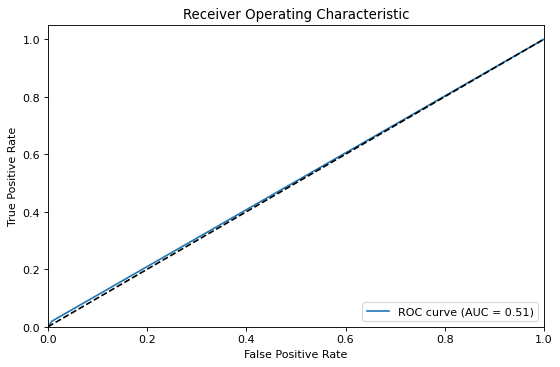

Linear SVM Accuracy: 0.7435601691657054
5
Accuracy: 0.7435601691657054
Precision: 1.0
Recall: 0.010385756676557863
F1 Score: 0.02055800293685756
Confusion Matrix: 
 [[1927    0]
 [ 667    7]]
AUC:  0.505192878338279


c:\Users\ellio\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


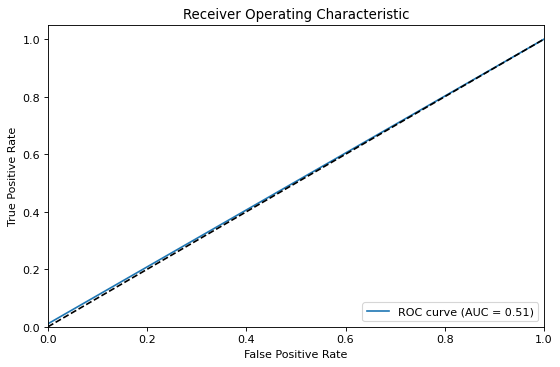

Linear SVM Accuracy: 0.7427912341407151
10
Accuracy: 0.7427912341407151
Precision: 0.5454545454545454
Recall: 0.04451038575667656
F1 Score: 0.0823045267489712
Confusion Matrix: 
 [[1902   25]
 [ 644   30]]
AUC:  0.5157684258830089


c:\Users\ellio\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


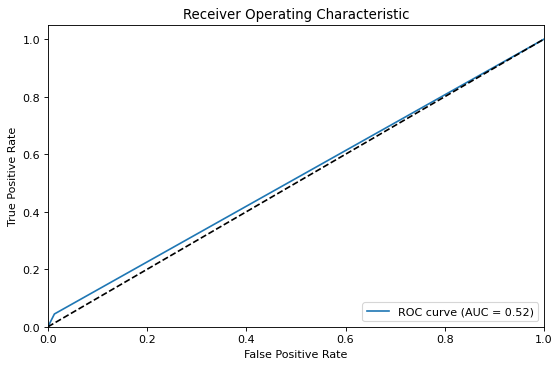

In [ ]:
from sklearn.svm import SVC, LinearSVC

for C in [0.1,0.5,1,5,10]:
    clf = LinearSVC(C=C)

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print("Linear SVM Accuracy:", accuracy)

    print(C)
    eval(y_test, y_pred)

# clf = SVC(kernel='poly')

# clf.fit(X_train, y_train)

# y_pred = clf.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred)
# print("Polynommial Accuracy:", accuracy)

# clf = SVC(kernel='rbf')

# clf.fit(X_train, y_train)

# y_pred = clf.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred)
# print("RBF Accuracy:", accuracy)

# clf = SVC(kernel='sigmoid')

# clf.fit(X_train, y_train)

# y_pred = clf.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred)
# print("Sigmoid Accuracy:", accuracy)

#### Random Forest

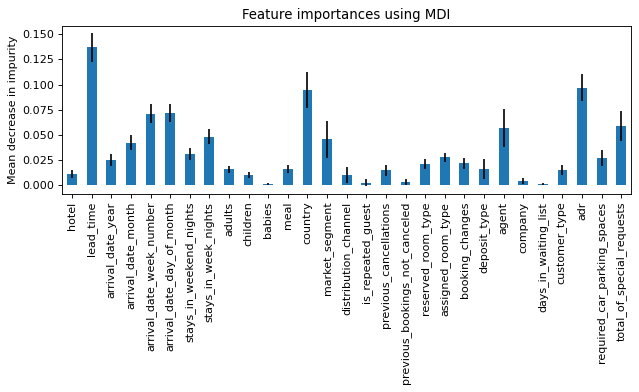

Accuracy: 0.8404459823144944
Precision: 0.7476099426386233
Recall: 0.5801186943620178
F1 Score: 0.6532999164578112
Confusion Matrix: 
 [[1795  132]
 [ 283  391]]
AUC:  0.755809217445669


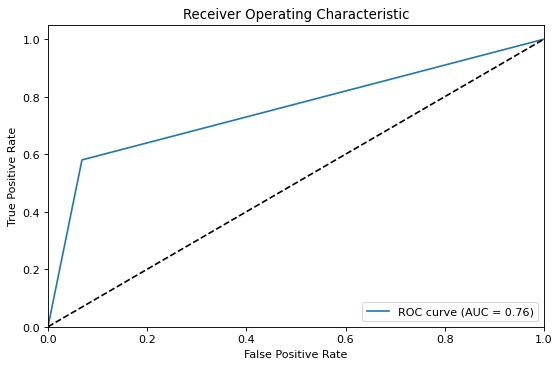

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create random forest classifier object
# increasing n_estimators to 500 increases runtime withoug meaningfully increasing AUC
# oob_score does not improve model
rf = RandomForestClassifier(n_estimators=100)

# Train the classifier on the training data
rf.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = rf.predict(X_test)

# Code from scikit learn documentation
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()


eval(y_test, y_pred)


In [ ]:
# Finding the best parameters for Random Forest classification

from sklearn.model_selection import GridSearchCV

parameters = {
    'n_estimators': [10, 25, 50, 100, 200],
    'max_depth': [5, 10, None],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf, param_grid=parameters, cv=5)

# Fit the grid search object to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print(grid_search.best_params_)
print(grid_search.best_score_)

{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
0.8242943347127698


Confusion Matrix: 
 [[1793  134]
 [ 277  397]]
AUC:  0.7597413146617102


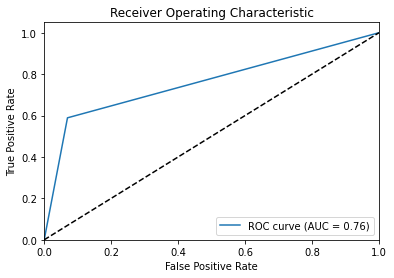

In [ ]:
# Using the optimal parameters

rf = RandomForestClassifier(max_depth=None,max_features='sqrt',min_samples_leaf=1, min_samples_split=5, n_estimators=100)
rf.fit(X_train,y_train)

y_pred = rf.predict(X_test)

eval(y_test,y_pred)


### Neural Nets

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
raise 'STOP HERE TO SAVE LAPTOP'

TypeError: exceptions must derive from BaseException

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'hidden_layer_sizes': [(10,), (20,), (30,), (10, 10), (20, 20), (30, 30)],
    'activation': ['relu', 'logistic', 'tanh'],
    'solver': ['adam', 'sgd', 'lbfgs'],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'alpha': randint(1, 100),
    'max_iter': randint(100, 1000)
}

random_search = RandomizedSearchCV(
    MLPClassifier(),
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best parameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)

c:\Users\ellio\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
c:\Users\ellio\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (443) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ellio\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
c:\Users\ellio\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (443) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ellio\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations 

Accuracy: 0.803921568627451
Precision: 0.5385756676557863
Recall: 0.6459074733096085
F1 Score: 0.587378640776699
Confusion Matrix: 
 [[1728  311]
 [ 199  363]]
AUC:  0.7466908626969819


C:\Users\Will\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


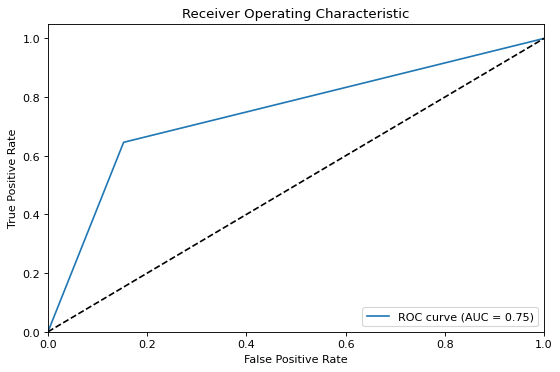

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(30,), activation = 'relu', alpha = 8, learning_rate = 'adaptive', solver = 'lbfgs', max_iter=1000)

mlp.fit(X_train,y_train)

y_pred = mlp.predict(X_test)

eval(y_pred, y_test)


---
## 4. Discussion & Conclusions


*In this section you should provide a general overview of **your final model**, its **performance**, and **reliability**.* 

Your report must include the following:

* Some discussion of the features that are most important for predicting a cancelation - we do not need discussion of specific coefficient values but direction of the effect should be clear (e.g. the earlier a booking is made the more likely it is to be canceled).

* A validated assessment of your model's performance, but this must be specifically discussed in the context of bookings and running a hotel. 

* It is not sufficient to report summary statistics like the accuracy or AUC - you must address the perfomance in terms of potential gains and losses for the hotel (e.g. think about what happens if your model predicts a cancelation that does not actually occur and a room ends up being double booked or vice versa). 

* Explain why you think your particular model would or would not be economically viable.

## 5. References

*In this section, you should present a list of external sources (except the course materials) that you used during the project, if any*

- Additional data sources can be cited here, in addition to related python documentations, any other webpage sources that you benefited from